<a href="https://colab.research.google.com/github/iknunyants/quick-draw-homework/blob/master/quick_draw_hw1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports

In [0]:
import zipfile
import numpy as np
import pandas as pd
import os
import tqdm
import matplotlib 
%matplotlib inline
import matplotlib.pyplot as plt
import csv

# Prepare Google Drive (for persistent storage)

In [0]:
from google.colab import drive
GOOGLE_DRIVE_MOUNT = "/content/gdrive"
drive.mount(GOOGLE_DRIVE_MOUNT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


# Download data from Kaggle

In [0]:
# we need to use python 3 version of Kaggle!
# remove python 2 version with `pip uninstall kaggle`
! pip3 install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [0]:
# get <token> from https://www.kaggle.com/<user>/account, click "Create New API Token", open json file
# ! KAGGLE_USERNAME=<user> KAGGLE_KEY=<token> kaggle competitions download -c quickdraw-doodle-recognition -f train_simplified.zip
! wget https://zianboo.blob.core.windows.net/blobs/train_simplified.zip -O train_simplified.zip

--2020-03-12 11:40:50--  https://zianboo.blob.core.windows.net/blobs/train_simplified.zip
Resolving zianboo.blob.core.windows.net (zianboo.blob.core.windows.net)... 52.239.223.132
Connecting to zianboo.blob.core.windows.net (zianboo.blob.core.windows.net)|52.239.223.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7917607098 (7.4G) [application/zip]
Saving to: ‘train_simplified.zip’

train_simplified.zi 100%[===================>]   7.37G  20.5MB/s    in 9m 9s   

2020-03-12 11:49:59 (13.8 MB/s) - ‘train_simplified.zip’ saved [7917607098/7917607098]



In [0]:
# open zip file, will read everything from it
zf = zipfile.ZipFile("train_simplified.zip")

# Data generators from disk (no need to store in RAM)

In [0]:
class_labels = map(lambda x: x.replace(".csv", ""), zf.namelist())
class_labels[:5]

['fence', 'yoga', 'horse', 'sandwich', 'cat']

In [0]:
# loop through file eternally
def get_eternal_csv_generator(fn, debug=False):
    while True:
        with zf.open(fn) as f:
            f.readline()  # skip header
            for line in csv.reader(f, delimiter=',', quotechar='"'):
                yield line[1], line[5]
            if debug:
                print fn, "is done, starting from the beginning..."

In [0]:
def raw_batch_generator(batch_size, debug=False):
    generators = np.array([get_eternal_csv_generator(fn, debug) for fn in zf.namelist()])
    while True:
        random_indices = np.random.randint(0, len(generators), size=batch_size)
        yield [gen.next() for gen in generators[random_indices]]

# Images generator

In [0]:
# copy-paste from https://www.kaggle.com/jpmiller/image-based-cnn

import ast
from PIL import Image, ImageDraw
import cv2

IMG_SIZE = 128

# faster conversion function
def draw_it(strokes):
    img = 255 * np.ones((256, 256), np.uint8)
    for stroke in ast.literal_eval(strokes):
        for i in range(len(stroke[0]) - 1):
            _ = cv2.line(img, (stroke[0][i], stroke[1][i]), (stroke[0][i + 1], stroke[1][i + 1]), 0, 3)
    return cv2.resize(img, (IMG_SIZE, IMG_SIZE))

In [0]:
def images_and_labels_generator(batch_size):
    for batch in raw_batch_generator(batch_size):
        batch_images = []
        batch_labels = []
        for e in batch:
            batch_images.append(draw_it(e[0]))
            batch_labels.append(e[1])
        batch_images = np.stack(batch_images, axis=0)
        yield batch_images, batch_labels

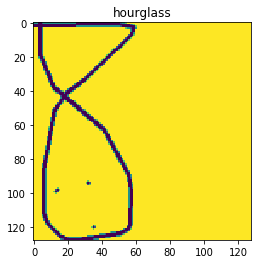

In [0]:
b = images_and_labels_generator(32).next()
plt.imshow(b[0][10, :, :])
plt.title(b[1][10])
plt.show()

# Augmentation example

Сначала я подкрутил параметры, которые вы дали. Я решил, что для оценки результатов аугментации мне стоит вручную менять параметры и смотреть на получающиеся картинки, а не запускать модель. Запустив раз десять соседние клетки, одно я понял точно: не все люди - художники. Чего стоят картинки класса "animal migration". Я уменьшил rotation_range до 25, потому что многие рисунки выходили из картинки и это не имело смысла. По той же причине я изменил zoom_range до 0.1. shear_range особо ни на что не влияет. Кроме того, можно добавить horizontal_flip=True, width_shift_range=0.1, height_shift_range=0.1.

Using TensorFlow backend.


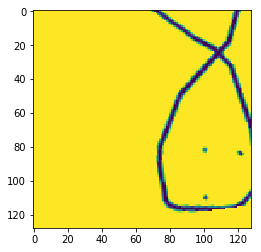

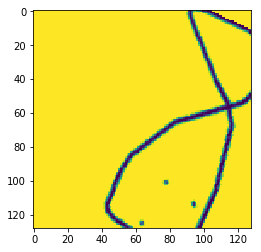

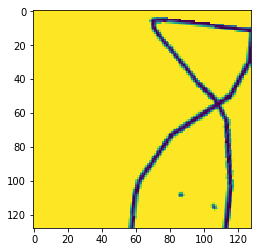

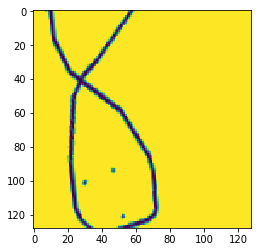

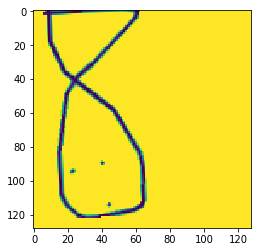

In [0]:
from keras.preprocessing.image import ImageDataGenerator

image_gen = ImageDataGenerator(
    rotation_range=30,
    shear_range=0.2,
    zoom_range=0.1,
    fill_mode='constant',
    cval=255,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

image = b[0][10, :, :]

# add 3 channels to image
image = np.tile(np.expand_dims(image, axis=2), (1, 1, 3))

# 5 random augmentations
for _ in range(5):
    plt.imshow(image_gen.random_transform(image)[:, :, 0])
    plt.show()

# Train simple network

In [0]:
import tensorflow as tf
import keras
from keras import backend as K

In [0]:
# reset graph when you change architecture!
def reset_tf_session():
    curr_session = tf.get_default_session()
    # close current session
    if curr_session is not None:
        curr_session.close()
    # reset graph
    K.clear_session()
    # create new session
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    s = tf.InteractiveSession(config=config)
    K.set_session(s)
    return s

In [0]:
NUM_CLASSES = len(class_labels)
class_to_idx = {c: idx for idx, c in enumerate(class_labels)}
class_to_idx.items()[:5]

[('snowman', 134),
 ('eyeglasses', 254),
 ('ceiling fan', 18),
 ('camel', 90),
 ('stove', 119)]

In [0]:
def train_iterator(batch_size):
    for batch in images_and_labels_generator(batch_size):
        images = batch[0].astype('float32')
        images = images / 255 - 0.5
        images = np.expand_dims(images, -1)
        labels = keras.utils.to_categorical(map(class_to_idx.get, batch[1]), NUM_CLASSES)
        yield images, labels

In [0]:
sample = train_iterator(32).next()
print sample[0].shape
print sample[1].shape

(32, 128, 128, 1)
(32, 340)


In [0]:
# import necessary building blocks
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D, \
    BatchNormalization, LeakyReLU, ReLU

**Dropout - нет, спасибо**

Изначально при написании модели добавил его после каждой свертки. Несмотря на то, что параметры были в районе 0.15, результаты на кагле были минимум на 0.05 хуже. В конечном счете из статей я узнал, что в большинстве случае использовать dropout после сверток неразумно, поэтому я от них отказася. Можно было бы использовать dropout после полносвязных слоёв, но у меня он только в конце. Можно было бы dropout использовать после полносвязного слоя, если бы я поставил Flatten() вместо GlobalAveragePooling2D, что я и проболва делать неоднократно, но это не улучшило результаты, зато добавило очень много параметров.

**Что делать перед GlobalAveragePooling2D?**

Очень долго я сохранял конструкцию при которой перед GlobalAveragePooling2D у меня стоял MaxPooling2D. В какой-то момент я решил попробовать заменить на свёртку понижающую размерность и это дало улучшение на 0.03 в kaggle при недолгом обучении модели. Думаю, намного лучше можно было бы увидеть разницу на больших эпохах и батче. 

**Лучше не пропускать левых пасажиров**

Конечно, не обошлось без опытов с функциями активаций. LeakyReLU для меня была альтернативой ReLU, но не долго прожила. Пробовал ставить alpha 0.3, 0.2, 0.1, 0.01 и понял, что лучше довериться классике, так как ReLU выдавал также результаты лучшие примерно на 0.04.

**Современные тренды**

Чтобы повысить score безусловно надо искать какие-то улучшения. Как оказалось, со временем лучшие архитектуры нейросетей используют меньший kernel. До этого моя модель преимущественно состояла из 5x5 свёрнок и пары 4x4, но поменяв все, кроме одной, на 3x3 скор подскачил, а параметров стало меньше. 

**Go deeper, not wider**

В продолжение к прошлому пункту я начал добавлять слои свёрток, чтобы на выходе у меня было бОльшая глубина изображения (иначе GlobalAveragePooling2D возвращал мало параметров), но при этом чтобы она изменяялась не больше чем в 2 раза. Ожидаемо, это привело к большему score'у.

In [0]:
def make_model():
    """
    Define your model architecture here.1
    Returns `Sequential` model.
    """
    model = Sequential()
    
    model.add(Conv2D(8, (3, 3), padding='same', activation='relu', input_shape=(IMG_SIZE, IMG_SIZE, 1)))
    model.add(BatchNormalization())
    model.add(Conv2D(16, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid'))

    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid'))

    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2,2), strides=(2,2), padding='valid'))
    
    model.add(Conv2D(128, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), padding='same', activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (4, 4), strides=(2, 2), padding='valid', activation='relu'))
    model.add(BatchNormalization())

    model.add(GlobalAveragePooling2D())

    model.add(Dense(NUM_CLASSES, activation="softmax"))
    
    return model

In [0]:
# describe model
s = reset_tf_session()  # clear default graph
model = make_model()
model.summary()

W0312 11:50:10.215817 140324409853824 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0312 11:50:10.218574 140324409853824 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0312 11:50:10.234503 140324409853824 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0312 11:50:11.766232 140324409853824 module_wrapper.py:139] From /usr/local/lib/python2.7/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0312 11:50:11.769551 14

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 128, 128, 8)       80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 128, 128, 8)       32        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 16)      1168      
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 128, 16)      64        
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 32)      4640      
_________________________________________________________________
batch_normalization_3 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 32)        0         
__________

In [0]:
# custom metrics we need
from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

In [0]:
import numpy as np

def apk(actual, predicted, k=10):

    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

def mapk(actual, predicted, k=3):
    return np.mean([apk(a,p,k) for a,p in zip(actual, predicted)])

In [0]:
BATCH_SIZE = 512
STEPS_PER_EPOCH = 300
EPOCHS = 35

s = reset_tf_session()  # clear default graph
model = make_model()  # define our model

# prepare model for fitting (loss, optimizer, etc)
model.compile(
    loss='categorical_crossentropy',
    optimizer=keras.optimizers.adam(clipnorm=5.),  # gradient clipping just in case
    metrics=[categorical_accuracy, top_3_accuracy]  # report top 3 accuracy, correlates with MAP@3!
)

In [0]:
# for saving the model after every epoch
from keras.models import save_model

class ModelSaveCallback(keras.callbacks.Callback):
    def __init__(self, file_name):
        super(ModelSaveCallback, self).__init__()
        self.file_name = file_name

    def on_epoch_end(self, epoch, logs=None):
        model_filename = self.file_name.format(epoch)
        save_model(self.model, model_filename)
        print("Model saved in {}".format(model_filename))

In [0]:
import os
GOOGLE_DRIVE_ROOT = GOOGLE_DRIVE_MOUNT + "/" + filter(lambda x: x[0] != '.', os.listdir(GOOGLE_DRIVE_MOUNT))[0]
print GOOGLE_DRIVE_ROOT

# will save checkpoints to Google Drive
CHECKPOINT_TEMPLATE = GOOGLE_DRIVE_ROOT + "/models/model_{}"
print CHECKPOINT_TEMPLATE

/content/gdrive/My Drive
/content/gdrive/My Drive/models/model_{}


In [0]:
last_finished_epoch = 0

# you can continue from snapshot!!!
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 17

# model = load_model(CHECKPOINT_TEMPLATE.format(last_finished_epoch), 
#                    custom_objects={"top_3_accuracy": top_3_accuracy})

In [0]:
# fit the model with our eternal generator!
model.fit_generator(
    train_iterator(BATCH_SIZE), 
    steps_per_epoch=STEPS_PER_EPOCH,
    epochs=EPOCHS,
    callbacks=[ModelSaveCallback(CHECKPOINT_TEMPLATE)],
    verbose=1,
    initial_epoch=last_finished_epoch
)

# Score test set

In [0]:
# download test set
! KAGGLE_USERNAME=ivanknu KAGGLE_KEY=cb3f739e7c61898325f835aa223e2eca kaggle competitions download -c quickdraw-doodle-recognition -f test_simplified.csv

test_simplified.csv.zip: Skipping, found more recently modified local copy (use --force to force download)


In [0]:
#! unzip test_simplified.csv.zip

In [0]:
def test_csv_iterator(batch_size):
    with open("test_simplified.csv", "r") as f:
        batch_keys = []
        batch_images = []
        f.readline()  # skip header
        for line in csv.reader(f, delimiter=',', quotechar='"'):
            batch_keys.append(line[0])
            batch_images.append(draw_it(line[2]))
            if len(batch_images) == batch_size:
                batch_images = np.stack(batch_images, axis=0)
                batch_images = np.expand_dims(batch_images, -1)
                batch_images = batch_images.astype('float32')
                batch_images = batch_images / 255 - 0.5
                yield batch_keys, batch_images
                batch_keys = []
                batch_images = []
        if batch_images:  # last batch
            batch_images = np.stack(batch_images, axis=0)
            batch_images = np.expand_dims(batch_images, -1)
            batch_images = batch_images.astype('float32')
            batch_images = batch_images / 255 - 0.5
            yield batch_keys, batch_images

In [0]:
! wc -l test_simplified.csv

112200 test_simplified.csv


In [0]:
with open("submission.csv", "w", buffering=1*1024*1024) as f:
    f.write("key_id,word\n")
    for batch_keys, batch_images in tqdm.tqdm(test_csv_iterator(BATCH_SIZE), total=np.ceil(112200./BATCH_SIZE)):
        probas = model.predict_proba(batch_images, BATCH_SIZE)
        top_3_classes = np.argsort(probas, axis=1)[:, [-1, -2, -3]]
        labels = map(lambda x: " ".join("_".join(class_labels[idx].split()) for idx in x), top_3_classes)
        for key, labels in zip(batch_keys, labels):
            f.write(key + "," + labels + "\n")


  0%|          | 0/220.0 [00:00<?, ?it/s]
  0%|          | 1/220.0 [00:00<02:16,  1.60it/s]
  1%|          | 2/220.0 [00:01<02:09,  1.69it/s]
  1%|▏         | 3/220.0 [00:01<02:02,  1.77it/s]
  2%|▏         | 4/220.0 [00:02<01:58,  1.82it/s]
  2%|▏         | 5/220.0 [00:02<01:54,  1.87it/s]
  3%|▎         | 6/220.0 [00:03<01:53,  1.89it/s]
  3%|▎         | 7/220.0 [00:03<01:51,  1.90it/s]
  4%|▎         | 8/220.0 [00:04<01:49,  1.93it/s]
  4%|▍         | 9/220.0 [00:04<01:48,  1.95it/s]
  5%|▍         | 10/220.0 [00:05<01:47,  1.95it/s]
  5%|▌         | 11/220.0 [00:05<01:46,  1.97it/s]
  5%|▌         | 12/220.0 [00:06<01:45,  1.97it/s]
  6%|▌         | 13/220.0 [00:06<01:44,  1.99it/s]
  6%|▋         | 14/220.0 [00:07<01:43,  1.98it/s]
  7%|▋         | 15/220.0 [00:07<01:44,  1.96it/s]
  7%|▋         | 16/220.0 [00:08<01:43,  1.97it/s]
  8%|▊         | 17/220.0 [00:08<01:43,  1.96it/s]
  8%|▊         | 18/220.0 [00:09<01:42,  1.96it/s]
  9%|▊         | 19/220.0 [00:09<01:42,  1.96it/

In [0]:
! wc -l submission.csv

112200 submission.csv


In [0]:
# submit to kaggle
! KAGGLE_USERNAME=ivanknu KAGGLE_KEY=cb3f739e7c61898325f835aa223e2eca kaggle competitions submit quickdraw-doodle-recognition -f submission.csv -m "bigaboom 512batch 300step 35epoch on 18th ep"

100% 4.42M/4.42M [00:03<00:00, 1.39MB/s]
Successfully submitted to Quick, Draw! Doodle Recognition Challenge